In [4]:
import datetime
import json

import numpy as np
from itertools import product
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered
from train_utils import train_model_regression
from evaluation_GTCNN import rNMSELoss, MSELossWithSparsityRegularizer, compute_iteration_rNMSE
from pred_utils import get_device, transform_data_to_all_steps_prediction, get_name_string, get_dataset, \
    get_MOLENE_dataset
from layers import CPGNN_ST, CPGNN_ST_v2, CPGNN_ST_v3, CITRUS, SGPModel
import networkx as nx
from Utilsss import get_evcs_evals

torch.cuda.current_device()

/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [5]:
device = get_device(use_gpu=True)

Device selected: cuda:0


In [6]:
ds_folder = "./"
splits = [0.35, 0.15, 0.5]
obs_window = 10

In [7]:
data, steps_ahead, weighted_adjacency = get_MOLENE_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window
)
N_spatial_nodes = weighted_adjacency.shape[0]
print(f"{N_spatial_nodes} nodes - {obs_window} observed timesteps - steps ahead: {steps_ahead}")



MOLENE is selected



Dataset path: ./dataset/processed/dataset_w=10_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
32 nodes - 10 observed timesteps - steps ahead: [1, 2, 3, 4, 5]


In [8]:
# Get data (We do not need test data/labels here)
trn_data, val_data, tst_data, trn_labels, val_labels, tst_labels = transform_data_to_all_steps_prediction(data, node_first=True, device=device)

trn_data = trn_data.float()
val_data = val_data.float()
tst_data = tst_data.float()
trn_labels = trn_labels.float()
val_labels = val_labels.float()
tst_labels = tst_labels.float()

In [9]:
# obtain one-step labels for the training
one_step_trn_labels = trn_labels[:, 0, :]  # [batch x step-ahead x nodes]
one_step_val_labels = val_labels[:, 0, :]
print(one_step_trn_labels.shape, one_step_val_labels.shape)

today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")


torch.Size([246, 32]) torch.Size([98, 32])


In [10]:
N_ITERATIONS = 10
num_epochs = 1500


learning_rate = 0.001
weight_decay = 0
batch_size = 64
patience = 150
factor = 0.9
lambda_value = 0.00025 # 0

not_learning_limit = 300

In [11]:
# CPGNN:
n_nodes = weighted_adjacency.shape[0]
M = obs_window
N = [n_nodes, M]
k = list(np.array(N)-2)
K_list = [30, 8]

In [12]:
adj = weighted_adjacency
Graph_List = [nx.from_numpy_array(np.array(adj)), nx.path_graph(obs_window)]

evecs, evals, L_list = get_evcs_evals(Graph_List, K_list)

for ii in range(len(evals)):
    evals[ii] = evals[ii].to(device)

[30, 8]
evecs.shape:,  torch.Size([32, 30])
evecs.shape:,  torch.Size([10, 8])
evecs_kron.shape:,  torch.Size([10, 8])


In [13]:
dim = 16
N_block = 3

In [14]:
res_dict = {
            'lr': learning_rate,
            'results': []
        }

for i in range(N_ITERATIONS):

    print(100*'*' + ' iter: ' + str(i) + 100*'*')
    one_step_gtcnn = CITRUS(input_size=1,
                                n_nodes=n_nodes,
                                horizon=1,
                                emb_size=dim,
                                hidden_size=dim,
                                rnn_layers=1,
                                gnn_kernel=1,
                                mass = torch.ones(np.prod(N)).to(device),
                                evals = evals,
                                evecs = torch.tensor(evecs).to(device),
                                C_width = dim,
                                N_block = N_block,
                                single_t = False,
                                use_gdc = [],
                                num_nodes = N,
                                last_activation=torch.nn.LeakyReLU(), 
                                mlp_hidden_dims=[dim, dim, dim, dim], 
                                dropout=False, 
                                with_MLP=False, 
                                diffusion_method='spectral', 
                                device = device,
                                graph_wise=False).to(device)
    print(one_step_gtcnn)

    model_parameters = filter(lambda p: p.requires_grad, one_step_gtcnn.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f"Number of parameters: {params}")


    # name_string = get_name_string(
    #     obs_window,
    #     feat_per_layer, taps_per_layer, time_pooling_ratio_per_layer,
    #     pool_reach_per_layer, active_nodes_per_timestep_per_layer,
    #     weight_decay, cyclic, lambda_value, time_directed
    # )
    # log_dir = f"./runs_MOLENE_w={obs_window}/{today}_lr={learning_rate}_b={batch_size}_{name_string}"

    log_dir = f"./runs_MOLENE_w={obs_window}/{today}_lr={learning_rate}_b={batch_size}_CPGNN_dim={dim}_l={N_block}_eig1={K_list[0]}_eig2={K_list[1]}"

    ### TRAINING ###
    loss_criterion = MSELossWithSparsityRegularizer(one_step_gtcnn, lambda_value) #torch.nn.MSELoss() #
    #torch.nn.MSELoss()

    val_metric = rNMSELoss()

    optimizer = torch.optim.Adam(one_step_gtcnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=factor)

    best_model, best_epoch = train_model_regression(
        Iter = i,
        model=one_step_gtcnn,
        training_data=trn_data, validation_data=val_data,  # [n_samples x 1 x nodes x timesteps]
        single_step_trn_labels=one_step_trn_labels, single_step_val_labels=one_step_val_labels,  # [n_samples x spatial_nodes]
        num_epochs=num_epochs, batch_size=batch_size,
        loss_criterion=loss_criterion, optimizer=optimizer, scheduler=scheduler,
        val_metric_criterion=val_metric,
        log_dir=log_dir,
        not_learning_limit=not_learning_limit
    )


    rNMSE_dict, predictions_dict = compute_iteration_rNMSE(best_model, steps_ahead, tst_data, tst_labels,
                                                           device, verbose=False)

    res_dict['results'].append([round(l.item(), 4) for l in list(rNMSE_dict.values())])

    means = [round(el, 4) for el in np.average(res_dict['results'], axis=0)]
    stds = [round(el, 4) for el in np.std(res_dict['results'], axis=0)]
    res_dict['final_res'] = {
        'avg': means,
        'std': stds
    }

    with open(log_dir + '/results.json', 'w', encoding='utf-8') as f:
        json.dump(res_dict, f, ensure_ascii=False, indent=4)

    print(res_dict['results'])

**************************************************************************************************** iter: 0****************************************************************************************************
CITRUS(
  (node_embeddings): NodeEmbedding(n_nodes=32, embedding_size=16)
  (encoder): Linear(in_features=17, out_features=16, bias=True)
  (CPGNN): CPGNN_ST_in_TTS(
    (last_activation): LeakyReLU(negative_slope=0.01)
    (first_lin): Linear(in_features=16, out_features=16, bias=True)
    (last_lin): Linear(in_features=16, out_features=16, bias=True)
    (merge_lin): Linear(in_features=320, out_features=1, bias=True)
    (node_embeddings): NodeEmbedding(n_nodes=32, embedding_size=4)
    (block_0): CPGNN_block_v2(
      (channel_mixer): Linear(in_features=16, out_features=16, bias=True)
      (diff_derivative): Time_derivative_diffusion_product(
        (Conv_layer): GCN_diff(
          (conv1): GCNConv(16, 16)
        )
      )
    )
    (block_1): CPGNN_block_v2(
      (channel

/tmp/ipykernel_474460/3685543249.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  evecs = torch.tensor(evecs).to(device),
/home/infres/benaziza-22/m2ds/graph_ml/CITRUS-Graph_ML/Molene/layers.py:338: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.diffusion_time)


Iter 0
 Epoch 0
	 train-loss: 5.798 | valid-loss: 6.5 	| valid-metric: 1.006 | lr: 0.001

				New best val_metric: 1.006. Saving model...

Iter 0
 Epoch 1
	 train-loss: 5.649 | valid-loss: 6.496 	| valid-metric: 1.005 | lr: 0.001

				New best val_metric: 1.005. Saving model...

Iter 0
 Epoch 2
	 train-loss: 5.577 | valid-loss: 6.497 	| valid-metric: 1.005 | lr: 0.001
Iter 0
 Epoch 3
	 train-loss: 5.487 | valid-loss: 6.501 	| valid-metric: 1.006 | lr: 0.001
Iter 0
 Epoch 4
	 train-loss: 5.385 | valid-loss: 6.513 	| valid-metric: 1.007 | lr: 0.001
Iter 0
 Epoch 5
	 train-loss: 5.288 | valid-loss: 6.527 	| valid-metric: 1.008 | lr: 0.001
Iter 0
 Epoch 6
	 train-loss: 5.105 | valid-loss: 6.546 	| valid-metric: 1.009 | lr: 0.001
Iter 0
 Epoch 7
	 train-loss: 4.994 | valid-loss: 6.576 	| valid-metric: 1.011 | lr: 0.001
Iter 0
 Epoch 8
	 train-loss: 4.917 | valid-loss: 6.606 	| valid-metric: 1.014 | lr: 0.001
Iter 0
 Epoch 9
	 train-loss: 4.822 | valid-loss: 6.619 	| valid-metric: 1.015 | lr

In [15]:
 
# print(res_dict['results'])
means = [round(el, 4) for el in np.average(res_dict['results'], axis=0)]
stds = [round(el, 4) for el in np.std(res_dict['results'], axis=0)]
print('means: ', means)
print('stds: ', stds)

means:  [0.2414, 0.3581, 0.4758, 0.5838, 0.6779]
stds:  [0.0431, 0.0372, 0.0301, 0.0228, 0.0162]


In [15]:
# print(res_dict['results'])
means = [round(el, 4) for el in np.average(res_dict['results'], axis=0)]
stds = [round(el, 4) for el in np.std(res_dict['results'], axis=0)]
print('means: ', means)
print('stds: ', stds)

means:  [0.2423, 0.3601, 0.4784, 0.5869, 0.6814]
stds:  [0.0526, 0.0473, 0.0398, 0.0316, 0.024]


In [16]:
res_dict['final_res'] = {
    'avg': means,
    'std': stds
}
with open(log_dir + '/results.json', 'w', encoding='utf-8') as f:
    json.dump(res_dict, f, ensure_ascii=False, indent=4)

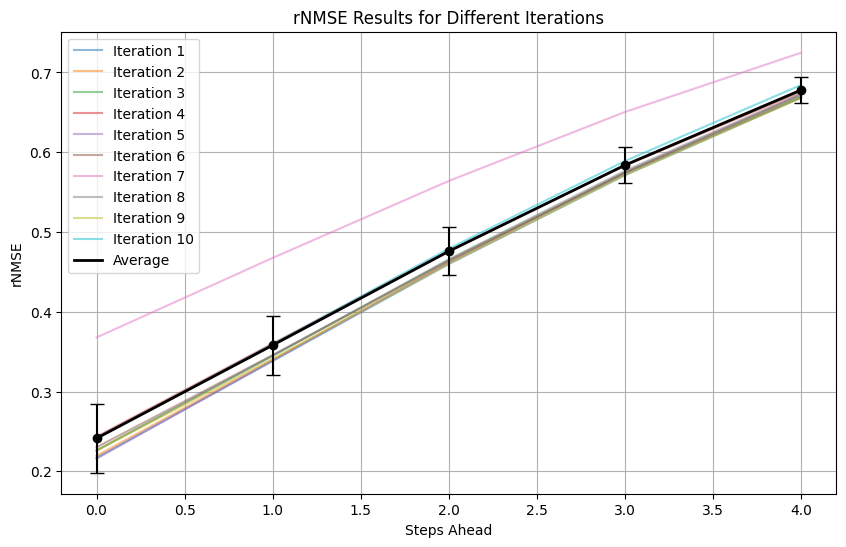

In [17]:
import json
import matplotlib.pyplot as plt

# Path to the results.json file
json_file_path = log_dir + '/results.json'
# Read the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Extract the results and final_res
results = data['results']
final_res = data['final_res']

# Convert results to a numpy array for easier manipulation
import numpy as np
results_array = np.array(results)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot each iteration's results
for i, result in enumerate(results):
    plt.plot(result, label=f'Iteration {i+1}', alpha=0.5)

# Plot the average results
plt.plot(final_res['avg'], label='Average', color='black', linewidth=2)

# Add error bars for the standard deviation
avg = np.array(final_res['avg'])
std = np.array(final_res['std'])
plt.errorbar(range(len(avg)), avg, yerr=std, fmt='o', color='black', capsize=5)

# Add labels and title
plt.xlabel('Steps Ahead')
plt.ylabel('rNMSE')
plt.title('rNMSE Results for Different Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()